https://www.kaggle.com/c/covid19-global-forecasting-week-1

In this challenge, you will be predicting the cumulative number of confirmed COVID19 cases in various locations across the world, as well as the number of resulting fatalities, for future dates.

We understand this is a serious situation, and in no way want to trivialize the human impact this crisis is causing by predicting fatalities. Our goal is to provide better methods for estimates that can assist medical and governmental institutions to prepare and adjust as pandemics unfold.

In [207]:
# debugging and formatter
from IPython.core.debugger import set_trace

"""load_ext nb_black"""

'load_ext nb_black'

In [208]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

plt.style.use(style="seaborn")
%matplotlib inline

In [209]:
!cd data && ls

test.csv  train.csv


In [210]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [211]:
train.head().T

,0,1,2,3,4
Id,1,2,3,4,5
Province/State,NaN,NaN,NaN,NaN,NaN
Country/Region,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan
Lat,33,33,33,33,33
Long,65,65,65,65,65
Date,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26
ConfirmedCases,0,0,0,0,0
Fatalities,0,0,0,0,0


In [212]:
test.head().T

,0,1,2,3,4
ForecastId,1,2,3,4,5
Province/State,NaN,NaN,NaN,NaN,NaN
Country/Region,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan
Lat,33,33,33,33,33
Long,65,65,65,65,65
Date,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16


In [213]:
train.isna().mean().round(4)

Id                0.0000
Province/State    0.5423
Country/Region    0.0000
Lat               0.0000
Long              0.0000
Date              0.0000
ConfirmedCases    0.0000
Fatalities        0.0000
dtype: float64

In [214]:
train["Province/State"].fillna("Unknown", inplace=True)
train["Lat"].fillna(-999, inplace=True)
train["Long"].fillna(-999, inplace=True)

Grouping by country and date and aggregating data.

In [215]:
data = (
    train.groupby(["Date", "Country/Region"])
    .agg({"ConfirmedCases": "sum", "Fatalities": "sum"})
    .reset_index()
)

In [216]:
data

,Date,Country/Region,ConfirmedCases,Fatalities
0,2020-01-22,Afghanistan,0.0,0.0
1,2020-01-22,Albania,0.0,0.0
2,2020-01-22,Algeria,0.0,0.0
3,2020-01-22,Andorra,0.0,0.0
4,2020-01-22,Antigua and Barbuda,0.0,0.0
...,...,...,...,...
10264,2020-03-24,Uruguay,162.0,0.0
10265,2020-03-24,Uzbekistan,50.0,0.0
10266,2020-03-24,Venezuela,84.0,0.0
10267,2020-03-24,Vietnam,134.0,0.0


In [217]:
test_data = (
    test.groupby(["Date", "Country/Region"])
    .last()
    .reset_index()[["Date", "Country/Region"]]
)

In [218]:
test_data

,Date,Country/Region
0,2020-03-12,Afghanistan
1,2020-03-12,Albania
2,2020-03-12,Algeria
3,2020-03-12,Andorra
4,2020-03-12,Antigua and Barbuda
...,...,...
7004,2020-04-23,Uruguay
7005,2020-04-23,Uzbekistan
7006,2020-04-23,Venezuela
7007,2020-04-23,Vietnam


In [219]:
data["Date"] = pd.to_datetime(data.Date)
test_data["Date"] = pd.to_datetime(test_data.Date)

In [220]:
print(f"Data Last Date: {data.Date.max()}")
print(f"Test Data First Date: {test_data.Date.min()}")

Data Last Date: 2020-03-24 00:00:00
Test Data First Date: 2020-03-12 00:00:00


In [221]:
countries = data["Country/Region"].unique()
test_countries = test_data["Country/Region"].unique()

In [222]:
set(countries) == set(test_countries)

True

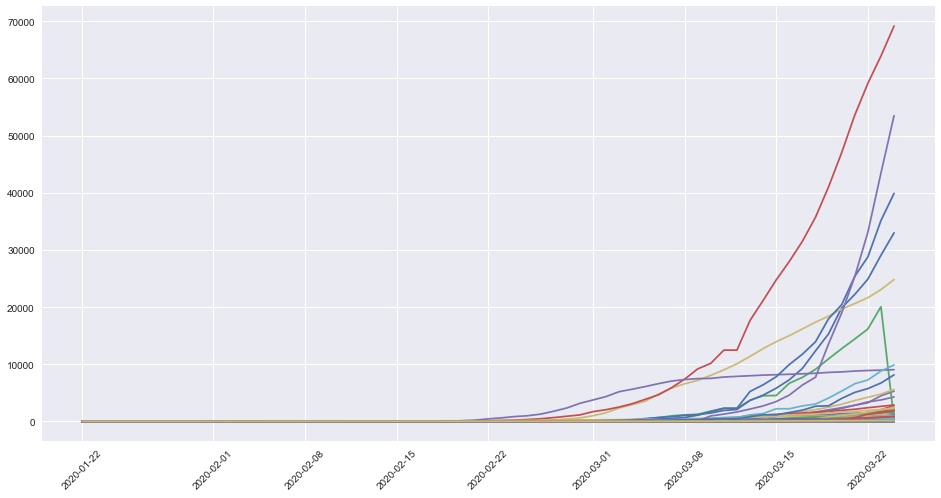

In [223]:
plt.figure(1, figsize=(16, 8))

for i in range(1, len(countries)):
    _data = data[data["Country/Region"] == countries[i - 1]]
    plt.xticks(rotation=45)
    if countries[i - 1] != "China":
        plt.plot(_data.Date, _data.ConfirmedCases)

### Check confirmed cases and fatalities per country.

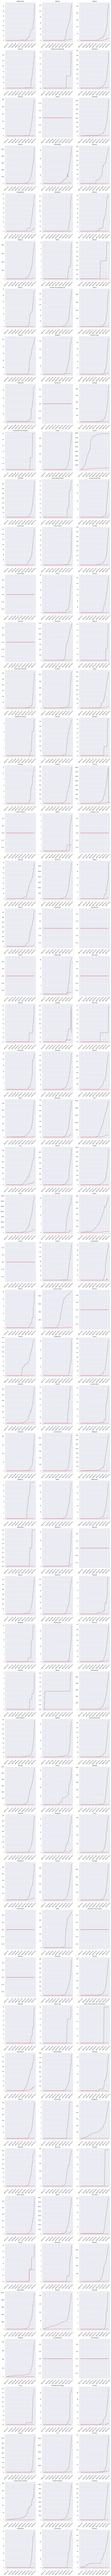

In [224]:
plt.figure(1, figsize=(16, 16 * 8))

for i in range(1, len(countries)):
    _data = data[data["Country/Region"] == countries[i - 1]]
    plt.subplots_adjust(top=2.5)
    plt.subplot(54, 3, i)
    plt.xticks(rotation=45)
    plt.title(countries[i - 1])
    plt.plot(_data.Date, _data.ConfirmedCases, color="grey")
    plt.plot(_data.Date, _data.Fatalities, color="r", alpha=0.7)

### Calculate the mortality rate.

Let's combine all the data to calculate the total number of cases and fatalities per country and calculate the mortality rate.

In [225]:
comb_data = data.groupby("Country/Region").agg(
    {"ConfirmedCases": "sum", "Fatalities": "sum"}
)

Choosing to filter by at least 1000 confirmed cases. As many countries have few confirmed cases, a mortality rate calculated on those wouldn't be representative.

In [226]:
comb_data = comb_data[comb_data.ConfirmedCases > 1000]
comb_data["FatalityPerc"] = 100 * comb_data.Fatalities / comb_data.ConfirmedCases

In [227]:
mortality_rate = comb_data.FatalityPerc.sort_values(ascending=False)
print(mortality_rate)

Country/Region
San Marino      8.438819
Italy           8.192697
Iraq            7.982894
Philippines     7.807716
Algeria         7.609428
                  ...   
South Africa    0.000000
Latvia          0.000000
Estonia         0.000000
Qatar           0.000000
Vietnam         0.000000
Name: FatalityPerc, Length: 69, dtype: float64


In [228]:
print(f"Median mortality rate: {mortality_rate.median()}")

Median mortality rate: 0.8752620545073375


Remove overlap between train and test set

In [229]:
print(f"Data Last Date: {data.Date.max()}")
print(f"Test Data First Date: {test_data.Date.min()}")

Data Last Date: 2020-03-24 00:00:00
Test Data First Date: 2020-03-12 00:00:00


In [230]:
valid = data[data.Date >= min(test_data.Date)]
train = data[data.Date < min(test_data.Date)]

### Predict number of confirmed cases per country.

In [231]:
test_data["ConfirmedCases"] = np.nan
test_data["Fatalities"] = np.nan

In [288]:
from sklearn import linear_model

In [289]:
for country in countries:
    _train = train[train["Country/Region"] == country]
    _test = test_data[test_data["Country/Region"] == country]
    confirmed = _train["ConfirmedCases"].values[-10:]
    fatalities = _train["Fatalities"].values[-10:]
    if np.sum(confirmed) > 0:
        X = np.arange(len(confirmed)).reshape(-1, 1)
        X_test = len(confirmed) + np.arange(len(_test)).reshape(-1, 1)

        model = LinearRegression()
        model.fit(X, confirmed)

        conf = model.predict(X_test)
        conf = np.clip(conf, 0, None)
        conf = conf - np.min(conf) + confirmed[-1]
        conf = np.ceil(conf)
        test_data.loc[test_data["Country/Region"] == country, "ConfirmedCases"] = conf

        model = LinearRegression()
        model.fit(X, fatalities)

        fatal = model.predict(X_test)
        fatal = np.clip(fatal, 0, None)
        fatal = fatal - np.min(fatal) + fatalities[-1]
        fatal = np.ceil(fatal)
        test_data.loc[test_data["Country/Region"] == country, "Fatalities"] = fatal

test_data[["ConfirmedCases", "Fatalities"]].fillna(0, inplace=True)

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


Let's evaluate the predictions by plotting the overlapping data.


In [290]:
valid.sort_values(["Country/Region", "Date"], inplace=True)
preds = test_data.sort_values(["Country/Region", "Date"])

preds = preds.copy()
valid = valid.copy()
preds = valid[["Country/Region", "Date"]].merge(
    preds, on=["Country/Region", "Date"], how="left"
)
preds.fillna(0, inplace=True)

In [291]:
valid["PredictedConfirmedCases"] = preds.ConfirmedCases.values
valid["PredictedFatalities"] = preds.Fatalities.values

In [292]:
valid.to_csv('submission.csv',index = False, header = True)

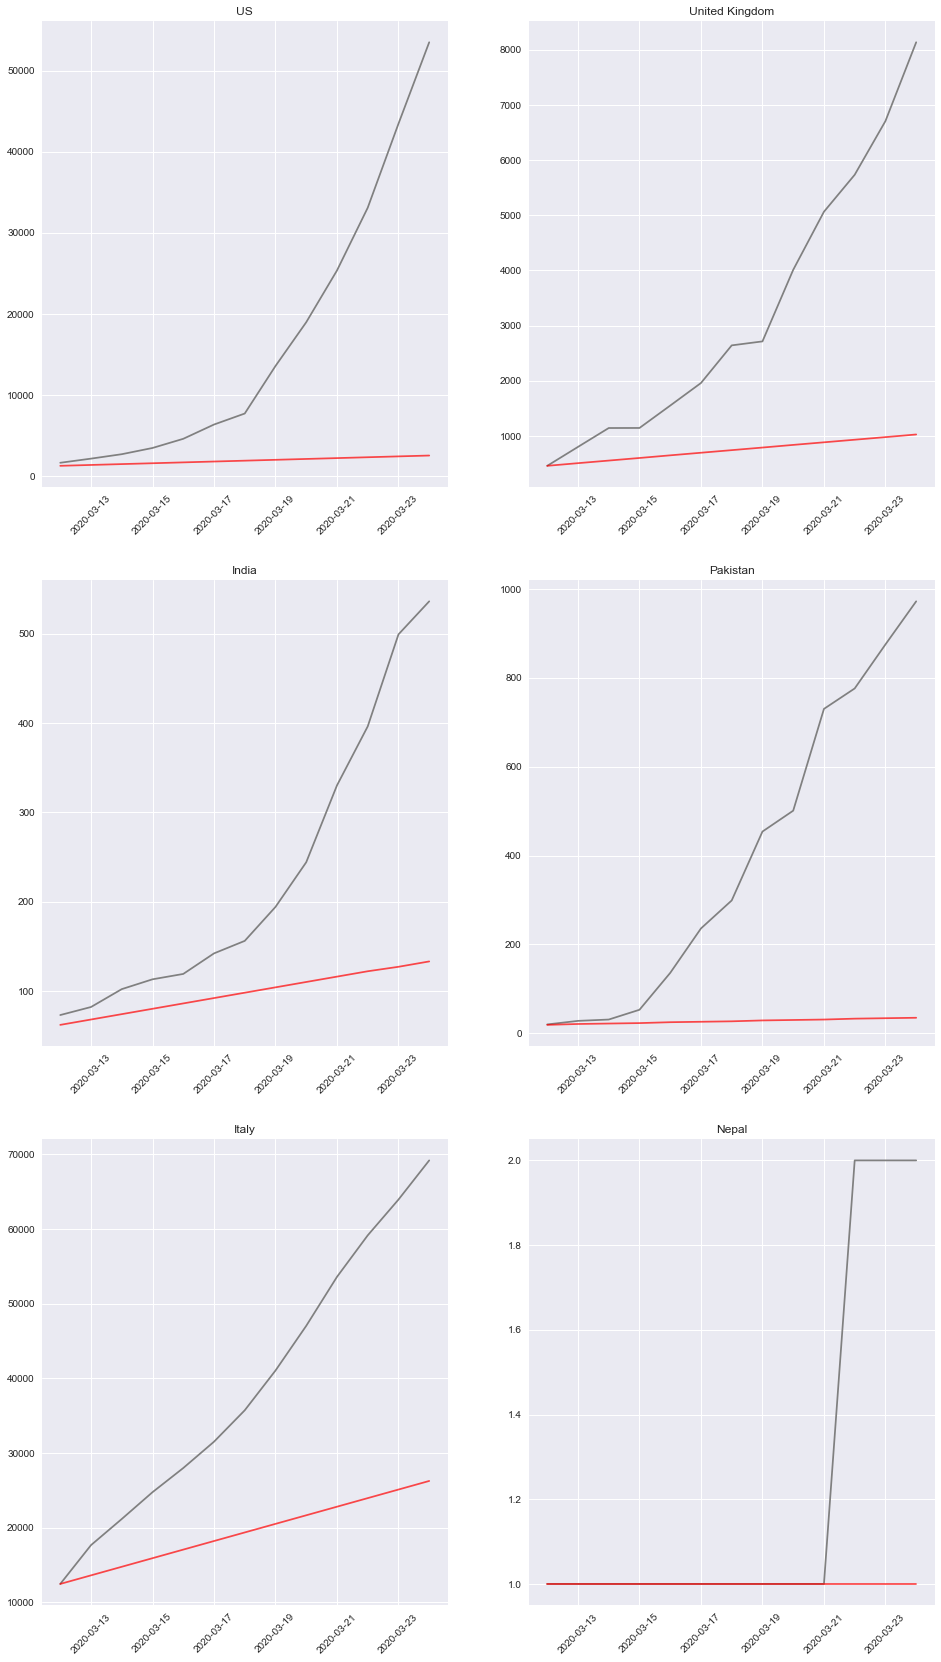

In [293]:
country_subset = ["US", "United Kingdom", "India", "Pakistan", "Italy", "Nepal"]
plt.figure(2, figsize=(16, 16))
for i in range(len(country_subset)):
    _data = valid[valid["Country/Region"] == country_subset[i]]
    plt.subplot(3, 2, i + 1)
    plt.subplots_adjust(top=1.5)
    plt.xticks(rotation=45)
    plt.title(country_subset[i])
    plt.plot(_data.Date, _data.ConfirmedCases, color="grey")
    plt.plot(_data.Date, _data.PredictedConfirmedCases, color="r", alpha=0.7)

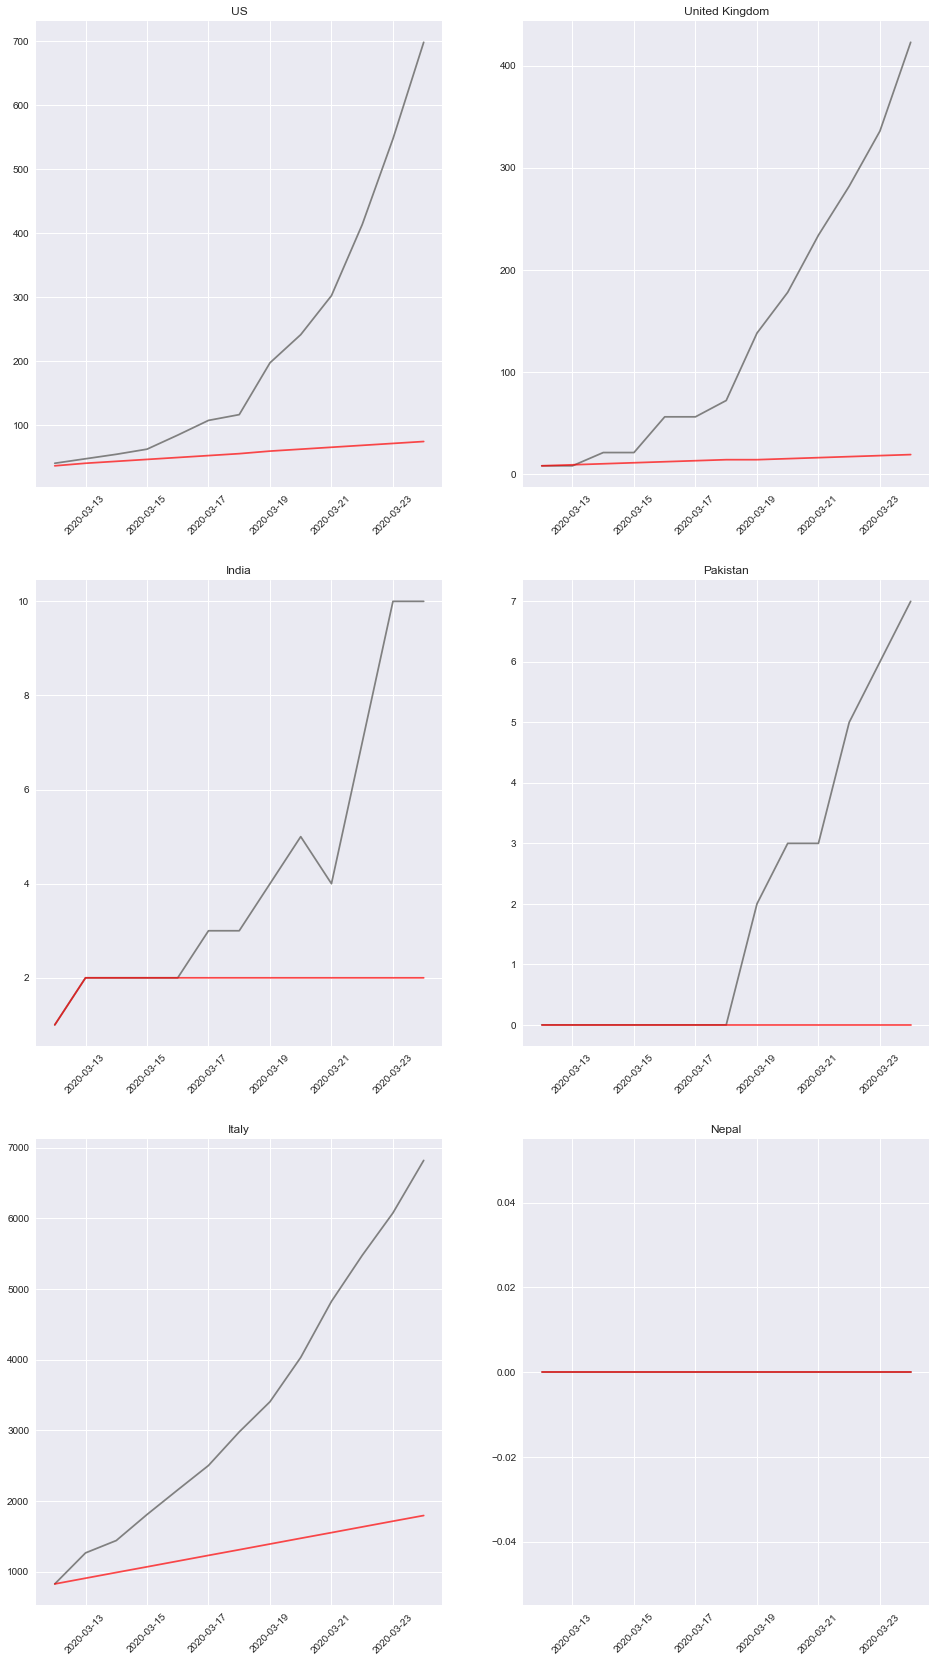

In [294]:
plt.figure(2, figsize=(16, 16))
for i in range(len(country_subset)):
    _data = valid[valid["Country/Region"] == country_subset[i]]
    plt.subplot(3, 2, i + 1)
    plt.subplots_adjust(top=1.5)
    plt.xticks(rotation=45)
    plt.title(country_subset[i])
    plt.plot(_data.Date, _data.Fatalities, color="grey")
    plt.plot(_data.Date, _data.PredictedFatalities, color="r", alpha=0.7)